### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import h2o 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import os

In [18]:
import interpret
import shap
from interpret.blackbox import ShapKernel, LimeTabular

# CREATE EXPLANATIONS FOR RANDOM FOREST 
**File**: 5_explanation_interpretml.ipynb

**Author**: Sebastian Benno Veuskens 

**Date**: 2024-07-28

**Data**: train and test (same as evaluated model)  


## Modify

**Working directory**

In [3]:
os.chdir("C:/Users/Sebastian's work/OneDrive - OptiMedis AG/Dokumente/Coding/High-Cost-patient-analysis")

**Parameters & Settings**

In [4]:
target = 'HC_Patient_Next_Year'
excluded = 'Total_Costs_Next_Year'

### Load data

In [5]:
# TODO: Delete frac part
frac=0.02

train = pd.read_csv('data/complete/unbalanced/train_validate.csv', sep=',', header=0).sample(frac=frac)
test = pd.read_csv('data/complete/unbalanced/test.csv', sep=',', header=0).sample(frac=frac)

### Transform categorical values

In [6]:
train['Sex'] = pd.factorize(train['Sex'])[0]
test['Sex'] = pd.factorize(test['Sex'])[0]

### Create train & test data set

In [7]:
predictors = [var for var in train.columns if var not in (target, excluded)]
X_train, y_train = train[predictors], train[target]
X_test, y_test = test[predictors], test[target]

## Model training & prediction

### scikit-learn random forest

In [8]:
model = RandomForestClassifier(n_estimators=1000, max_features=30, random_state=12345)
model.fit(X_train, y_train)

RandomForestClassifier(max_features=30, n_estimators=1000, random_state=12345)

In [9]:
prediction_probs = model.predict_proba(X_test)[:,1]
predictions = model.predict(X_test)

## Model evaluation
#TODO: Change all train[predictors] to X_train etc. 

### ROC-AUC

In [10]:
fpr, tpr, _ = roc_curve(y_test, prediction_probs)
roc_auc = auc(fpr, tpr)

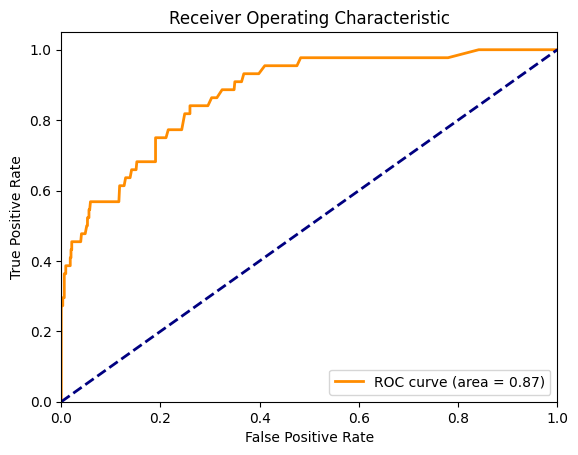

In [11]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall-AUC

In [12]:
precision, recall, _ = precision_recall_curve(y_test, prediction_probs)
pr_auc = auc(recall, precision)

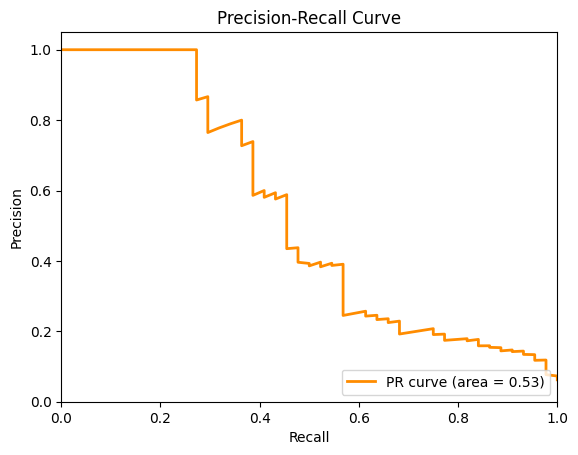

In [13]:
# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

In [14]:
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

[[663   0]
 [ 43   1]]


## XAI METHODS

### MODIFY

In [15]:
# TODO: Figure out what exactly I do with this number/if I should change it 
num_vars = 5    # Indicate how many samples to explain

### SHAP 

In [21]:
# Due to size of data set, summarization techniques are required
X_train_summary = shap.kmeans(X_train, 200)

In [22]:
# shap = ShapKernel(model, X_train)
shap = ShapKernel(model, X_train_summary)
shap_local = shap.explain_local(X_test[:num_vars], y_test[:num_vars])

 20%|██        | 1/5 [00:41<02:46, 41.57s/it]

In [ ]:
interpret.show(shap_local)

### LIME 

In [ ]:
lime = LimeTabular(model, X_train)
test_local_x = X_test[:num_vars]
test_local_y = y_test[:num_vars]

In [ ]:
exp_lime = lime.explain_local(test_local_x, test_local_y)
interpret.show(exp_lime, 0)

### PDP 

In [ ]:
pdp_iml = interpret.blackbox.PartialDependence(model, X_train)
pdp_global_iml = pdp_iml.explain_global()

In [ ]:
# TODO: Check why there is a one in interpret.show(pdp...)
interpret.show(pdp_iml.explain_global(), 1)

### Morris Sensitivity Analysis 

In [ ]:
msa_iml = interpret.blackbox.MorrisSensitivity(model, X_train)
msa_global_iml = msa_iml.explain_global()

In [ ]:
interpret.show(msa_global_iml, 0)

### Dashboard 

In [ ]:
interpret.show([shap_local, exp_lime, pdp_global_iml])